In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Define G10 currency pairs against USD
asian_currencies = ["JPY", "CNY", "HKD", "SGD", "KRW", "INR", "IDR", "MYR", "THB", "PHP"]
fx_tickers = [f"{curr}=X" for curr in asian_currencies]
# Fetch historical FX data
def get_fx_data(tickers, start="2020-01-01", end=None):
    fx_data = yf.download(tickers, start=start, end=end, progress=False)
    
    # Extract only 'Close' prices, handling multi-index
    if isinstance(fx_data.columns, pd.MultiIndex):
#         display(fx_data)
        fx_data = fx_data.xs('Close', axis=1, level=0)  # Get only the 'Close' column
    return fx_data

# Get FX rates
fx_rates = get_fx_data(fx_tickers)


# Rename columns for clarity
fx_rates.columns = asian_currencies

fx_rates

,JPY,CNY,HKD,SGD,KRW,INR,IDR,MYR,THB,PHP
Date,,,,,,,,,,
2020-01-01,6.9623,7.78650,13690.372070,71.275803,108.681000,1153.750000,4.0880,50.700001,1.33450,29.680000
2020-01-02,6.9622,7.79250,13689.231445,71.025002,108.712997,1153.969971,4.0880,50.700001,1.34519,30.059999
2020-01-03,6.9634,7.78830,13884.786133,71.415001,108.542999,1157.150024,4.0850,50.603596,1.34690,30.139999
2020-01-06,6.9645,7.78150,13934.316406,71.731003,107.963997,1165.849976,4.1000,51.067001,1.34978,30.143999
2020-01-07,6.9745,7.77040,13926.500000,71.787003,108.405998,1167.420044,4.1000,51.165001,1.34917,30.139999
...,...,...,...,...,...,...,...,...,...,...
2025-02-27,7.2580,7.77302,16367.400391,87.162201,148.837997,1434.420044,4.4265,57.790001,1.33758,33.740002
2025-02-28,7.2853,7.77681,16553.699219,87.327003,150.011993,1449.859985,4.4525,57.974998,1.34790,34.049999
2025-03-03,7.2828,7.77773,16522.000000,87.463997,150.770996,1459.800049,4.4600,57.840000,1.34940,34.202999


In [43]:
fx_data = fx_rates
# Step 2: Find Cointegrated Pairs (Using p-values from Engle-Granger test)
def find_cointegrated_pairs(fx_data):
    n = fx_data.shape[1]
    coint_pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            p_value = ts.coint(fx_data.iloc[:, i], fx_data.iloc[:, j])[1]
            if p_value < 0.05:  # Cointegration threshold
                coint_pairs.append((fx_data.columns[i], fx_data.columns[j], p_value))
    return sorted(coint_pairs, key=lambda x: x[2])  # Sort by strongest cointegration

cointegrated_pairs = find_cointegrated_pairs(fx_data)
best_pair = cointegrated_pairs[0][:2]  # Select most cointegrated pair
print(f"Selected Pair: {best_pair}")

# Step 3: Compute Spread & Moving Averages
pair1, pair2 = best_pair
spread = fx_data[pair1] / fx_data[pair2]  # Price ratio as spread
short_ma = spread.rolling(window=10).mean()
long_ma = spread.rolling(window=50).mean()




Selected Pair: ('HKD', 'INR')


In [44]:
cointegrated_pairs

[('HKD', 'INR', 0.00030373957842940553),
 ('HKD', 'KRW', 0.0008316668830388017),
 ('HKD', 'MYR', 0.0012478656812035251),
 ('HKD', 'SGD', 0.0026127002167353522),
 ('INR', 'MYR', 0.0031386412965457382),
 ('JPY', 'HKD', 0.012323811823579734)]

## Generating Trade signals
-- Buy Signal (Signal = 1): <br>
If the Z-score is less than -z_threshold, it means the spread is significantly below its mean and is expected to revert upward. The strategy buys the spread (long Pair1, short Pair2).<br><br>
-- Sell Signal (Signal = -1):<br>
If the Z-score is greater than z_threshold, it means the spread is significantly above its mean and is expected to revert downward. The strategy sells the spread (short Pair1, long Pair2). <br><br>
-- No Signal (Signal = 0):<br>
If the Z-score is within the threshold range, no action is taken.

For some pairs the opposite might be true <br>
If the spread consistently trends in one direction, you can reverse the trading logic:
Buy Signal (Signal = 1):<br>
If the Z-score is greater than z_threshold, buy the spread (long Pair1, short Pair2) to profit from the expected continuation of the trend.<br><br>
Sell Signal (Signal = -1):<br>
If the Z-score is less than -z_threshold, sell the spread (short Pair1, long Pair2) to profit from the expected continuation of the trend.
This approach assumes that the spread will continue to trend rather than revert to its mean.<br><br>

Pair JPY-CNY has too long mean reversion half-life: 275.88 days


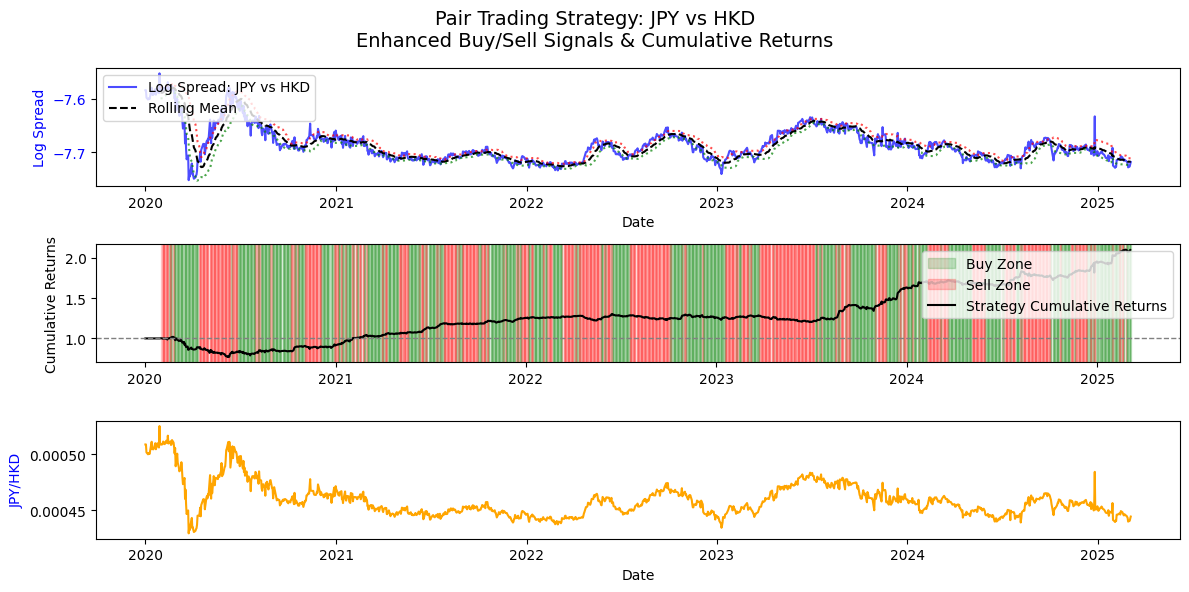

,Z-Score,Signal,JPY,HKD,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,6.9623,13690.372070,NaN,NaN
2020-01-02,NaN,0.0,6.9622,13689.231445,0.000000,1.000000
2020-01-03,NaN,0.0,6.9634,13884.786133,-0.000000,1.000000
2020-01-06,NaN,0.0,6.9645,13934.316406,-0.000000,1.000000
2020-01-07,NaN,0.0,6.9745,13926.500000,0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,-0.577056,1.0,7.2580,16367.400391,-0.001832,2.093789
2025-02-28,-1.633727,1.0,7.2853,16553.699219,-0.007535,2.078012
2025-03-03,-1.359899,1.0,7.2828,16522.000000,0.001575,2.081284


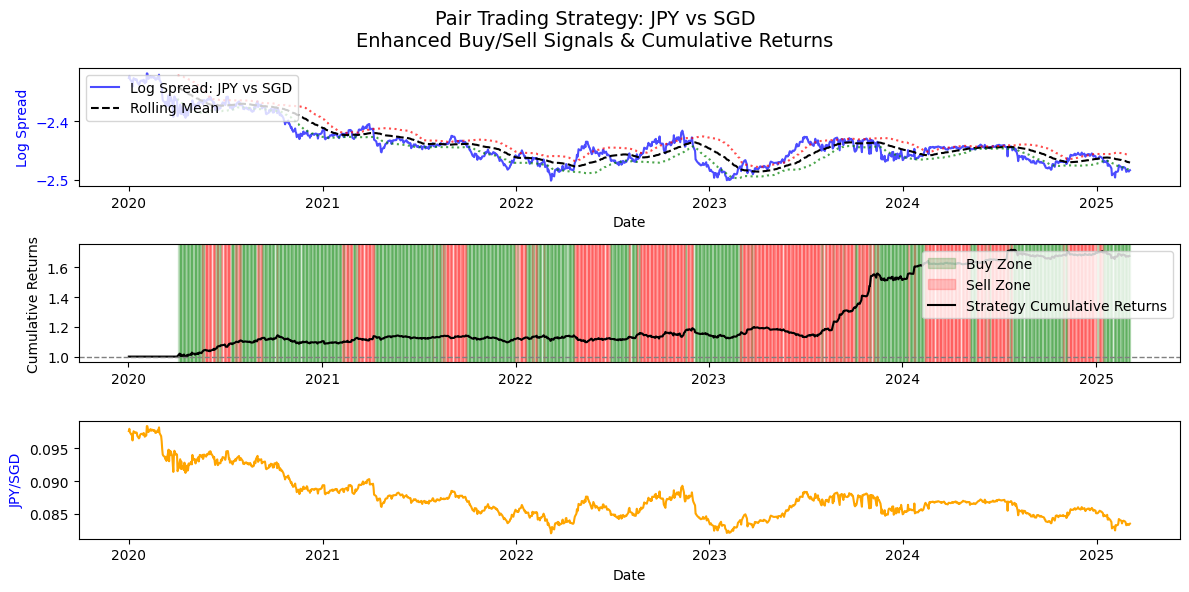

,Z-Score,Signal,JPY,SGD,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,6.9623,71.275803,NaN,NaN
2020-01-02,NaN,0.0,6.9622,71.025002,0.000000,1.000000
2020-01-03,NaN,0.0,6.9634,71.415001,-0.000000,1.000000
2020-01-06,NaN,0.0,6.9645,71.731003,-0.000000,1.000000
2020-01-07,NaN,0.0,6.9745,71.787003,0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,-1.380653,1.0,7.2580,87.162201,0.000504,1.672637
2025-02-28,-1.190738,1.0,7.2853,87.327003,0.001867,1.675760
2025-03-03,-1.307354,1.0,7.2828,87.463997,-0.001909,1.672561


Pair JPY-KRW has too long mean reversion half-life: 368.25 days
Pair JPY-INR has too long mean reversion half-life: 102.78 days


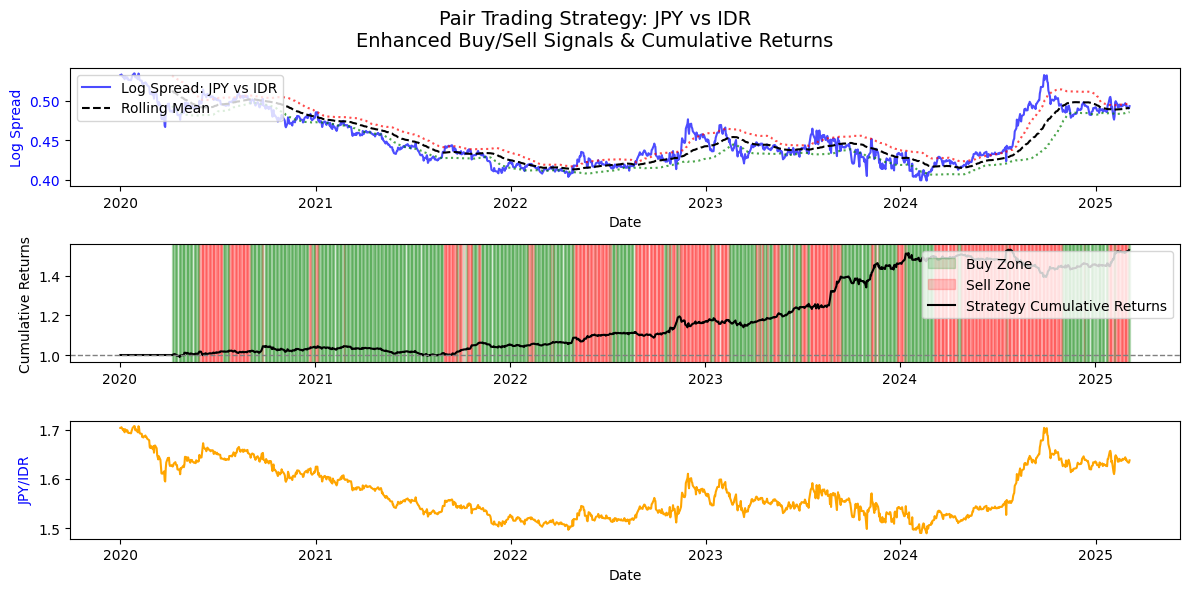

,Z-Score,Signal,JPY,IDR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,6.9623,4.0880,NaN,NaN
2020-01-02,NaN,0.0,6.9622,4.0880,-0.000000,1.000000
2020-01-03,NaN,0.0,6.9634,4.0850,0.000000,1.000000
2020-01-06,NaN,0.0,6.9645,4.1000,-0.000000,1.000000
2020-01-07,NaN,0.0,6.9745,4.1000,0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,0.731016,-1.0,7.2580,4.4265,-0.000417,1.519762
2025-02-28,0.327610,-1.0,7.2853,4.4525,0.002100,1.522954
2025-03-03,-0.066898,-1.0,7.2828,4.4600,0.002024,1.526037


Pair JPY-MYR has too long mean reversion half-life: 92.59 days
Pair JPY-THB has too long mean reversion half-life: 329.28 days
Pair JPY-PHP has too long mean reversion half-life: 107.66 days


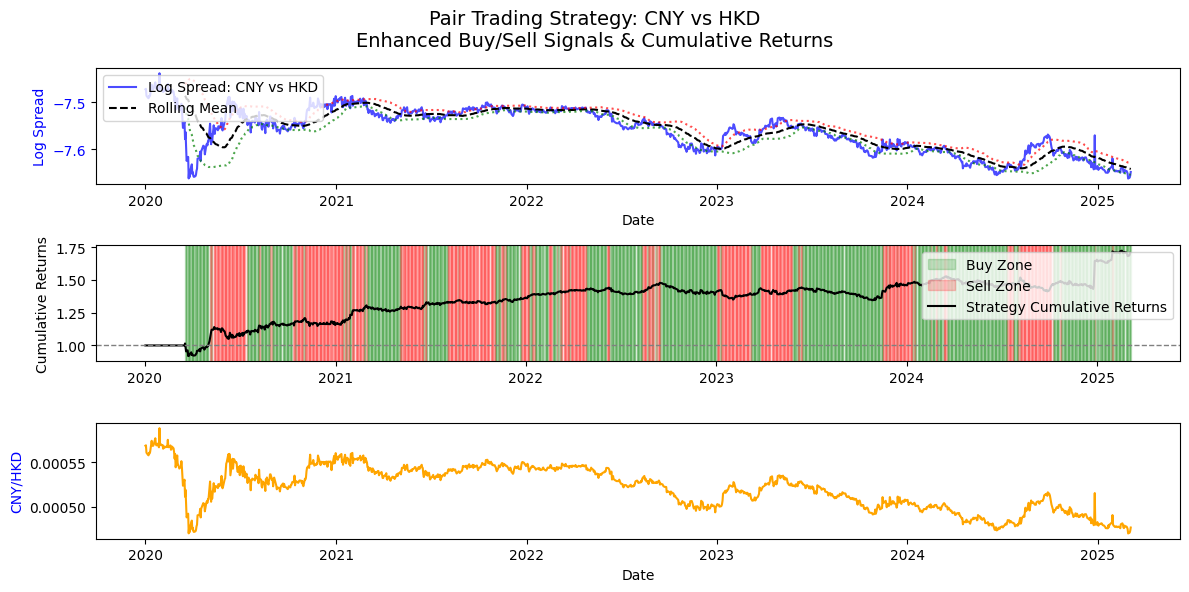

,Z-Score,Signal,CNY,HKD,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,7.78650,13690.372070,NaN,NaN
2020-01-02,NaN,0.0,7.79250,13689.231445,0.000000,1.000000
2020-01-03,NaN,0.0,7.78830,13884.786133,-0.000000,1.000000
2020-01-06,NaN,0.0,7.78150,13934.316406,-0.000000,1.000000
2020-01-07,NaN,0.0,7.77040,13926.500000,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,-0.957037,1.0,7.77302,16367.400391,-0.003288,1.701106
2025-02-28,-1.760017,1.0,7.77681,16553.699219,-0.010772,1.682782
2025-03-03,-1.530382,1.0,7.77773,16522.000000,0.002037,1.686210


Pair CNY-SGD has too long mean reversion half-life: 367.92 days
Pair CNY-KRW has too long mean reversion half-life: 849.60 days
Pair CNY-INR has too long mean reversion half-life: 346.03 days
Pair CNY-IDR has too long mean reversion half-life: 225.87 days
Pair CNY-MYR has too long mean reversion half-life: 303.65 days


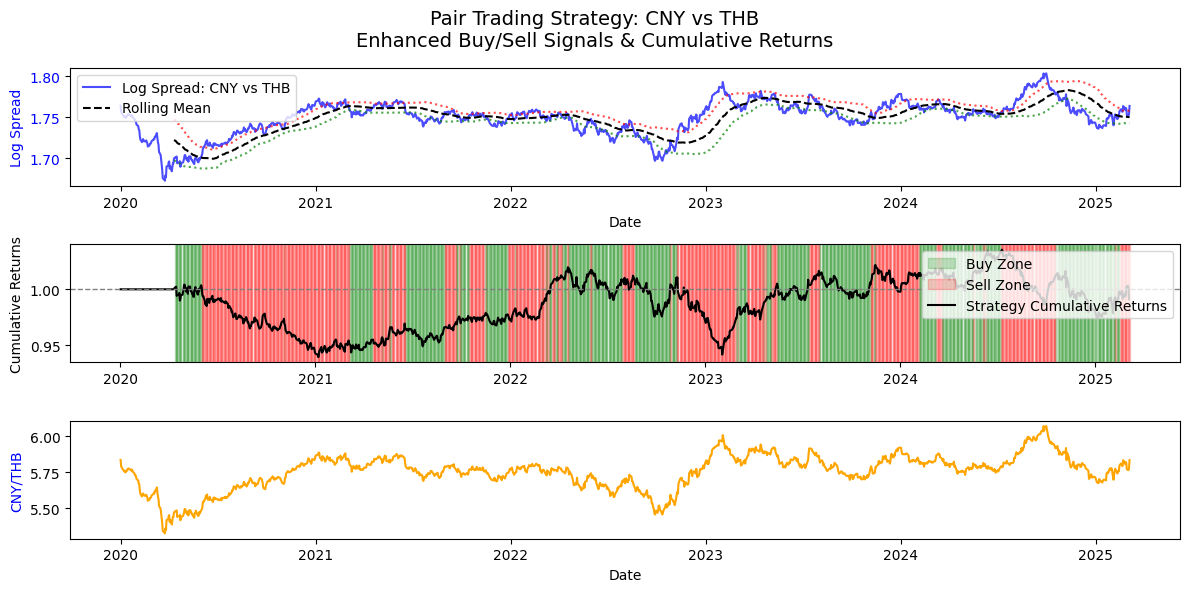

,Z-Score,Signal,CNY,THB,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,7.78650,1.33450,NaN,NaN
2020-01-02,NaN,0.0,7.79250,1.34519,-0.000000,1.000000
2020-01-03,NaN,0.0,7.78830,1.34690,-0.000000,1.000000
2020-01-06,NaN,0.0,7.78150,1.34978,-0.000000,1.000000
2020-01-07,NaN,0.0,7.77040,1.34917,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.216678,-1.0,7.77302,1.33758,0.001498,0.995105
2025-02-28,0.297996,-1.0,7.77681,1.34790,0.007173,1.002242
2025-03-03,0.186966,-1.0,7.77773,1.34940,0.000993,1.003238


Pair CNY-PHP has too long mean reversion half-life: 141.50 days


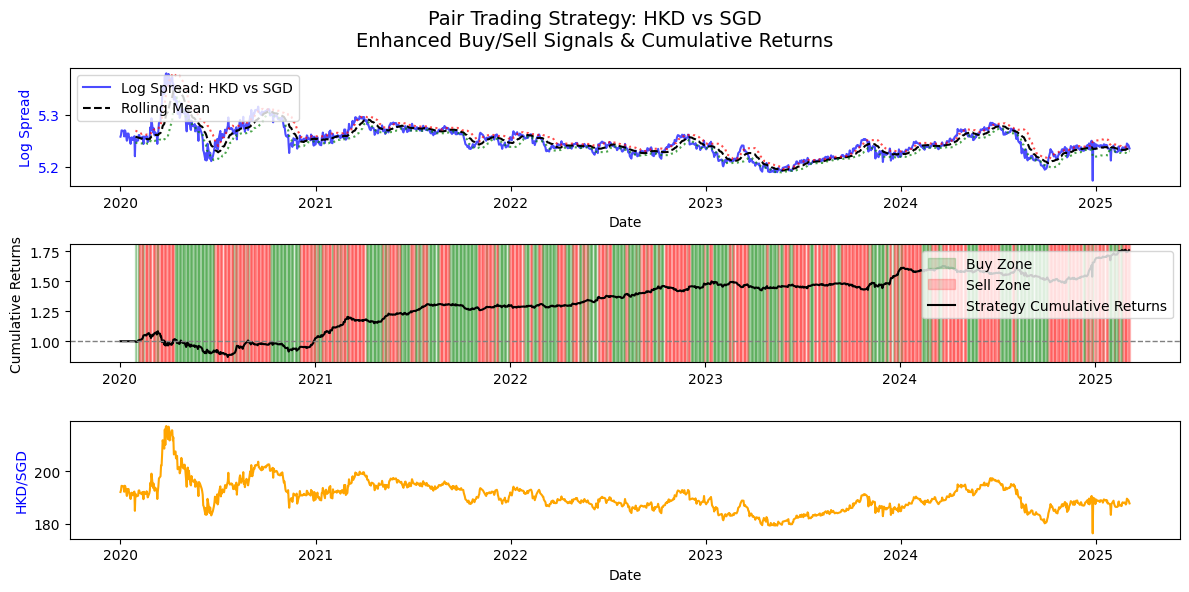

,Z-Score,Signal,HKD,SGD,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,13690.372070,71.275803,NaN,NaN
2020-01-02,NaN,0.0,13689.231445,71.025002,0.000000,1.000000
2020-01-03,NaN,0.0,13884.786133,71.415001,0.000000,1.000000
2020-01-06,NaN,0.0,13934.316406,71.731003,-0.000000,1.000000
2020-01-07,NaN,0.0,13926.500000,71.787003,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,0.411912,-1.0,16367.400391,87.162201,-0.002341,1.758681
2025-02-28,2.357965,-1.0,16553.699219,87.327003,-0.009474,1.742020
2025-03-03,1.427895,-1.0,16522.000000,87.463997,0.003478,1.748079


Pair HKD-KRW has too long mean reversion half-life: 237.95 days


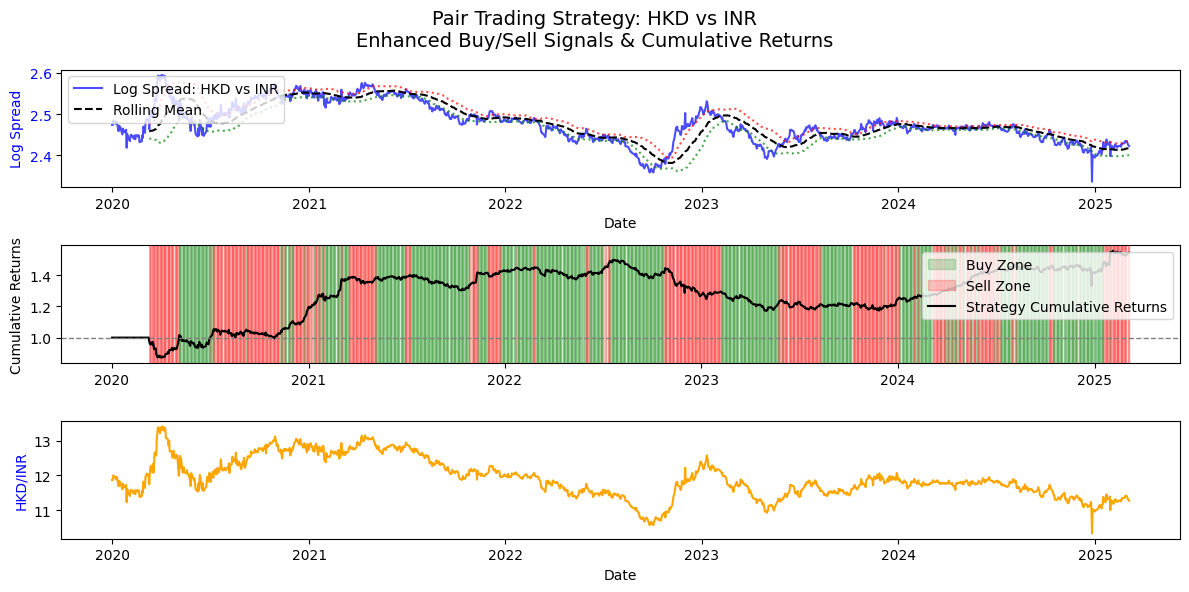

,Z-Score,Signal,HKD,INR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,13690.372070,1153.750000,NaN,NaN
2020-01-02,NaN,0.0,13689.231445,1153.969971,-0.000000,1.000000
2020-01-03,NaN,0.0,13884.786133,1157.150024,0.000000,1.000000
2020-01-06,NaN,0.0,13934.316406,1165.849976,-0.000000,1.000000
2020-01-07,NaN,0.0,13926.500000,1167.420044,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.127898,-1.0,16367.400391,1434.420044,0.000168,1.526911
2025-02-28,1.120555,-1.0,16553.699219,1449.859985,-0.000612,1.525977
2025-03-03,0.571222,-1.0,16522.000000,1459.800049,0.008711,1.539269


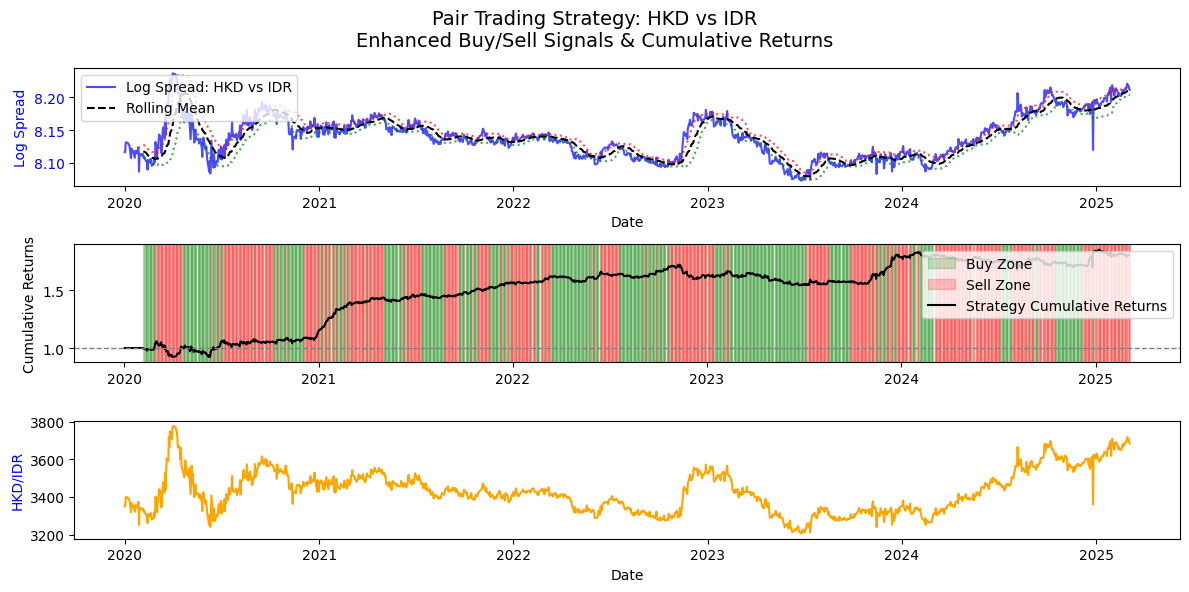

,Z-Score,Signal,HKD,IDR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,13690.372070,4.0880,NaN,NaN
2020-01-02,NaN,0.0,13689.231445,4.0880,-0.000000,1.000000
2020-01-03,NaN,0.0,13884.786133,4.0850,0.000000,1.000000
2020-01-06,NaN,0.0,13934.316406,4.1000,-0.000000,1.000000
2020-01-07,NaN,0.0,13926.500000,4.1000,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.164569,-1.0,16367.400391,4.4265,-0.002253,1.805412
2025-02-28,1.879427,-1.0,16553.699219,4.4525,-0.005476,1.795525
2025-03-03,1.191232,-1.0,16522.000000,4.4600,0.003593,1.801977


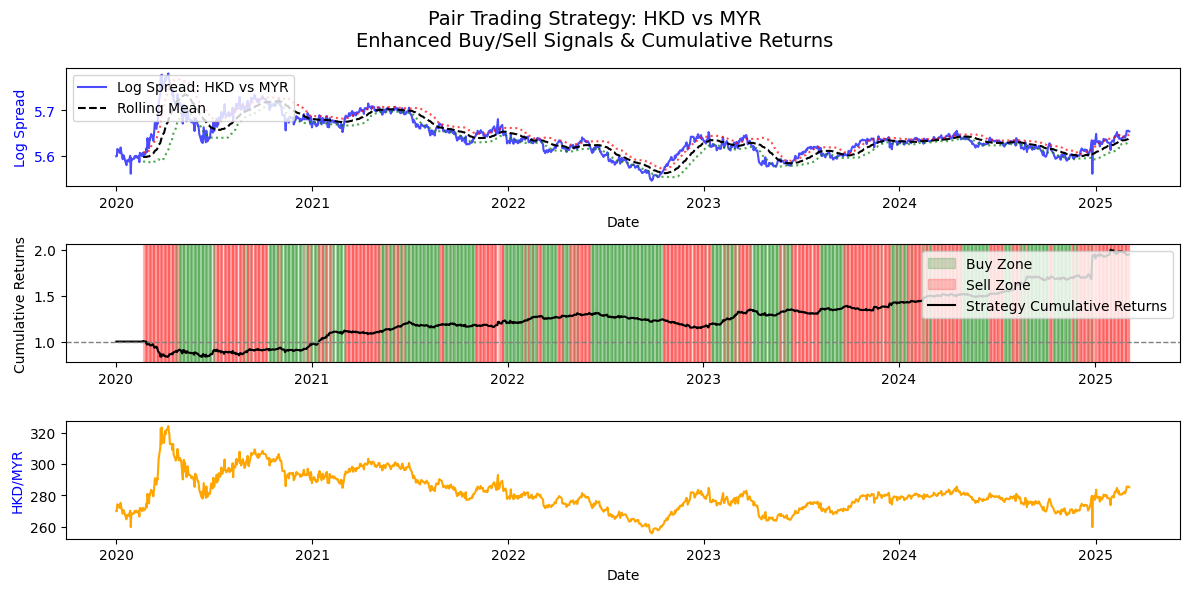

,Z-Score,Signal,HKD,MYR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,13690.372070,50.700001,NaN,NaN
2020-01-02,NaN,0.0,13689.231445,50.700001,-0.000000,1.000000
2020-01-03,NaN,0.0,13884.786133,50.603596,0.000000,1.000000
2020-01-06,NaN,0.0,13934.316406,51.067001,-0.000000,1.000000
2020-01-07,NaN,0.0,13926.500000,51.165001,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.444477,-1.0,16367.400391,57.790001,-0.002839,1.964423
2025-02-28,2.220507,-1.0,16553.699219,57.974998,-0.008155,1.948403
2025-03-03,2.113362,-1.0,16522.000000,57.840000,-0.000415,1.947595


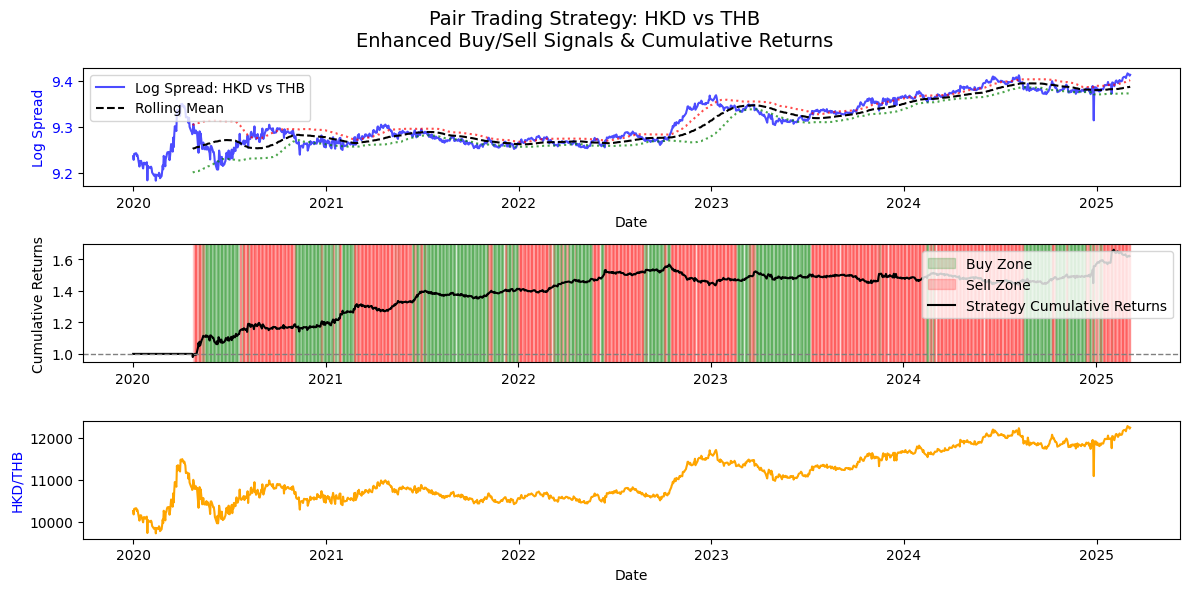

,Z-Score,Signal,HKD,THB,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,13690.372070,1.33450,NaN,NaN
2020-01-02,NaN,0.0,13689.231445,1.34519,-0.000000,1.000000
2020-01-03,NaN,0.0,13884.786133,1.34690,0.000000,1.000000
2020-01-06,NaN,0.0,13934.316406,1.34978,0.000000,1.000000
2020-01-07,NaN,0.0,13926.500000,1.34917,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,2.031799,-1.0,16367.400391,1.33758,-0.001796,1.621131
2025-02-28,2.214131,-1.0,16553.699219,1.34790,-0.003639,1.615233
2025-03-03,1.921448,-1.0,16522.000000,1.34940,0.003024,1.620118


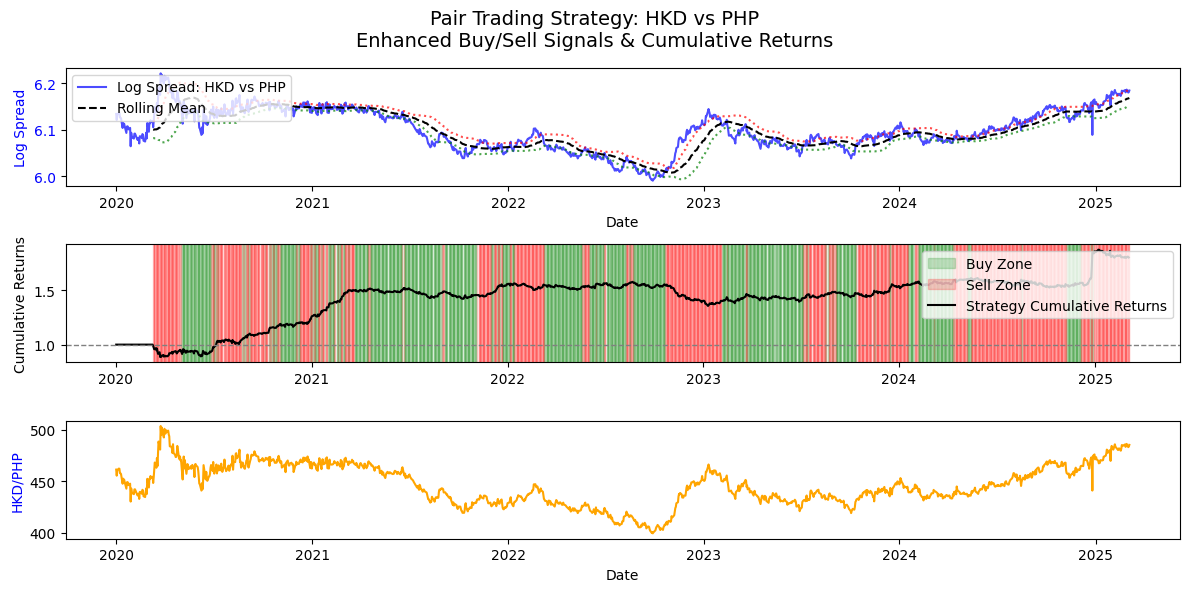

,Z-Score,Signal,HKD,PHP,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,13690.372070,29.680000,NaN,NaN
2020-01-02,NaN,0.0,13689.231445,30.059999,-0.000000,1.000000
2020-01-03,NaN,0.0,13884.786133,30.139999,0.000000,1.000000
2020-01-06,NaN,0.0,13934.316406,30.143999,0.000000,1.000000
2020-01-07,NaN,0.0,13926.500000,30.139999,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.079334,-1.0,16367.400391,33.740002,-0.003749,1.803431
2025-02-28,1.157507,-1.0,16553.699219,34.049999,-0.002174,1.799510
2025-03-03,0.757122,-1.0,16522.000000,34.202999,0.006380,1.810990


Pair SGD-KRW has too long mean reversion half-life: 287.80 days


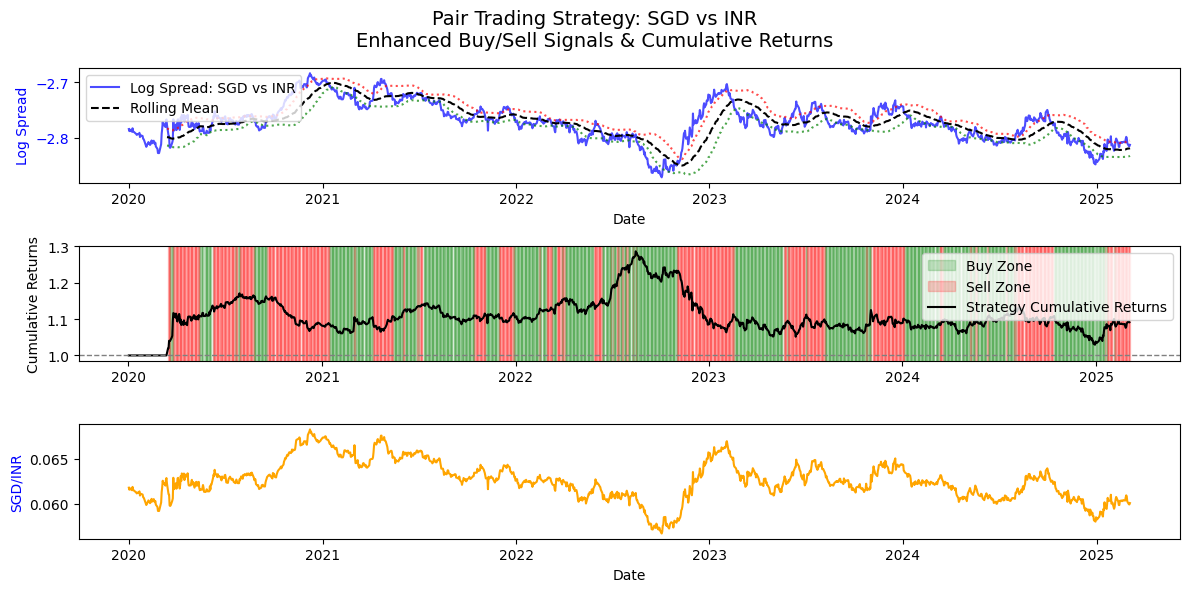

,Z-Score,Signal,SGD,INR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,71.275803,1153.750000,NaN,NaN
2020-01-02,NaN,0.0,71.025002,1153.969971,-0.000000,1.000000
2020-01-03,NaN,0.0,71.415001,1157.150024,0.000000,1.000000
2020-01-06,NaN,0.0,71.731003,1165.849976,-0.000000,1.000000
2020-01-07,NaN,0.0,71.787003,1167.420044,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.372614,-1.0,87.162201,1434.420044,0.002503,1.078588
2025-02-28,0.710594,-1.0,87.327003,1449.859985,0.008779,1.088057
2025-03-03,0.318248,-1.0,87.463997,1459.800049,0.005251,1.093770


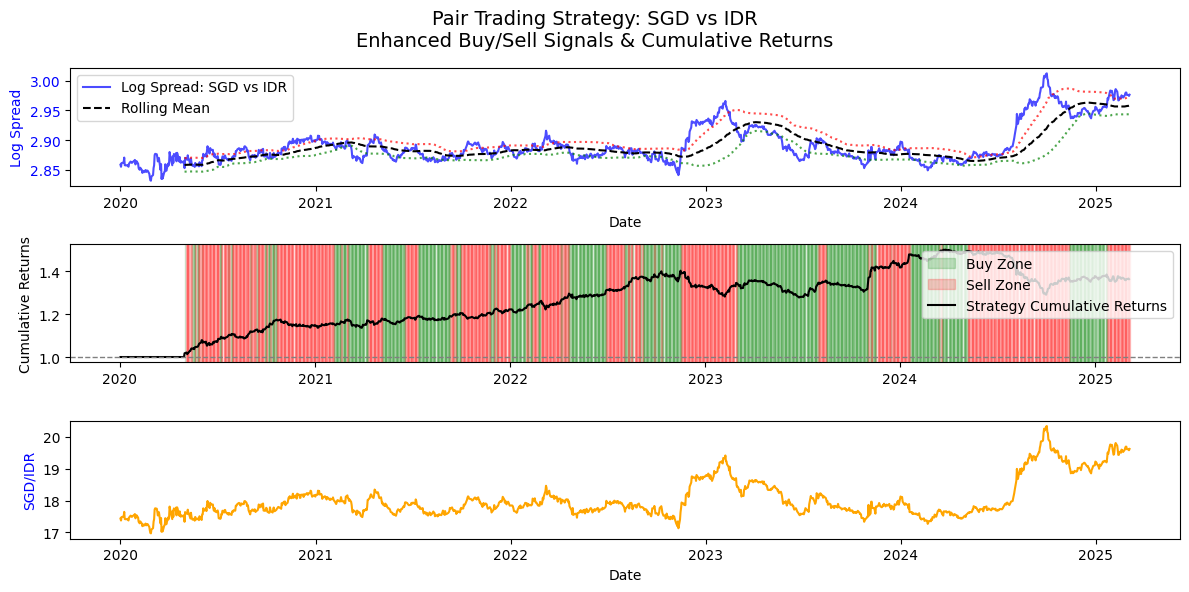

,Z-Score,Signal,SGD,IDR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,71.275803,4.0880,NaN,NaN
2020-01-02,NaN,0.0,71.025002,4.0880,-0.000000,1.000000
2020-01-03,NaN,0.0,71.415001,4.0850,0.000000,1.000000
2020-01-06,NaN,0.0,71.731003,4.1000,0.000000,1.000000
2020-01-07,NaN,0.0,71.787003,4.1000,0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.642460,-1.0,87.162201,4.4265,0.000087,1.358691
2025-02-28,1.330637,-1.0,87.327003,4.4525,0.003960,1.364071
2025-03-03,1.293769,-1.0,87.463997,4.4600,0.000116,1.364229


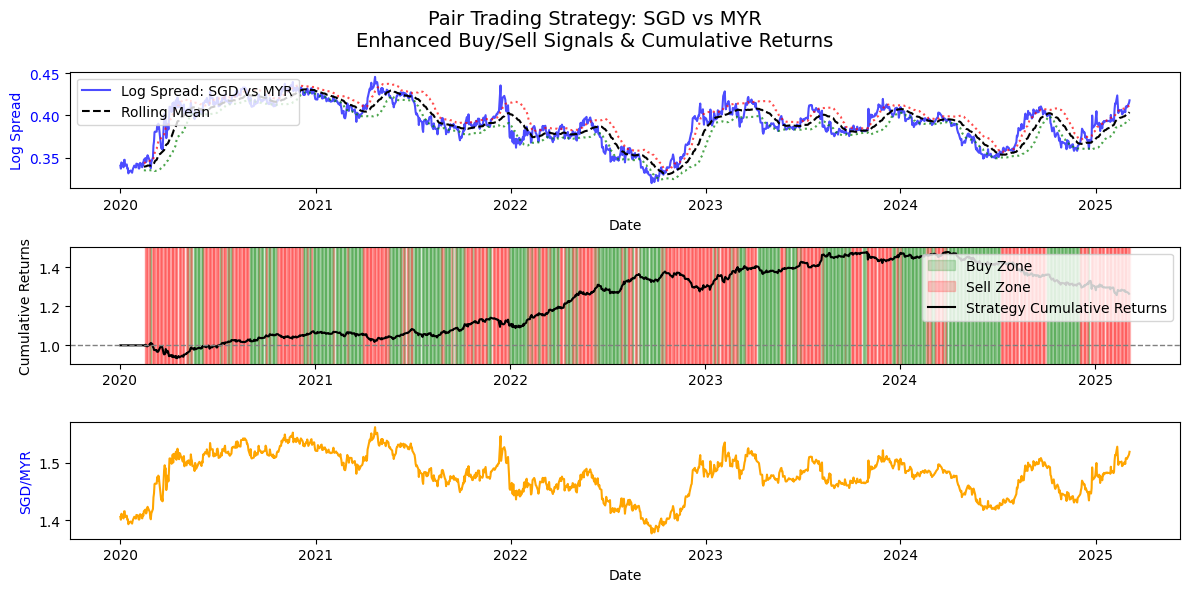

,Z-Score,Signal,SGD,MYR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,71.275803,50.700001,NaN,NaN
2020-01-02,NaN,0.0,71.025002,50.700001,-0.000000,1.000000
2020-01-03,NaN,0.0,71.415001,50.603596,0.000000,1.000000
2020-01-06,NaN,0.0,71.731003,51.067001,-0.000000,1.000000
2020-01-07,NaN,0.0,71.787003,51.165001,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.143708,-1.0,87.162201,57.790001,-0.000497,1.273789
2025-02-28,0.931921,-1.0,87.327003,57.974998,0.001306,1.275452
2025-03-03,1.311427,-1.0,87.463997,57.840000,-0.003906,1.270470


Pair SGD-THB has too long mean reversion half-life: 663.52 days
Pair SGD-PHP has too long mean reversion half-life: 121.30 days
            Z-Score  Signal        SGD        MYR  Returns  Cumulative Returns
Date                                                                          
2020-01-01      NaN     NaN  71.275803  50.700001      NaN                 NaN
2020-01-02      NaN     0.0  71.025002  50.700001     -0.0                 1.0
2020-01-03      NaN     0.0  71.415001  50.603596      0.0                 1.0
2020-01-06      NaN     0.0  71.731003  51.067001     -0.0                 1.0
2020-01-07      NaN     0.0  71.787003  51.165001     -0.0                 1.0


In [54]:

# Step 2: Find Cointegrated Pairs Using Johansen Test
def johansen_cointegration_test(fx_data, det_order=0, k_ar_diff=1):
    result = coint_johansen(fx_data, det_order, k_ar_diff)
    return result.lr1, result.cvt  # Trace statistics and critical values

trace_stats, critical_values = johansen_cointegration_test(fx_data)
cointegrated_pairs = []

for i in range(len(asian_currencies)):
    for j in range(i + 1, len(asian_currencies)):
        if trace_stats[i] > critical_values[i, 1]:  # 5% significance level
            cointegrated_pairs.append((asian_currencies[i], asian_currencies[j]))

ST_trade_signal = pd.DataFrame()
# cointegrated_pairs
for best_pair in cointegrated_pairs:
    pair1, pair2 = best_pair
    # Step 3: Compute Log Spread & Z-Score
    spread = np.log(fx_data[pair1]) - np.log(fx_data[pair2])
    price = fx_data[pair1] / fx_data[pair2]

    # Compute half-life of mean reversion
    spread_diff = spread.diff().dropna()
    X = np.vstack([spread.shift(1).dropna(), np.ones(len(spread_diff))]).T
    beta = np.linalg.lstsq(X, spread_diff.values, rcond=None)[0][0]
    half_life = -np.log(2) / beta

    # # If half-life is too long (> 50 days), discard the pair
    if half_life > 90:
        print(f"Pair {pair1}-{pair2} has too long mean reversion half-life: {half_life:.2f} days")
            
    else:

        # Compute rolling mean and standard deviation for Z-score
        window = int(half_life)  # Use half-life as moving window
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        z_score = (spread - spread_mean) / spread_std

        # Step 4: Generate Trading Signals with Adaptive Z-Score Threshold
        z_threshold = spread.rolling(100).std().mean()

        signals = pd.DataFrame(index=fx_data.index)
        signals['Z-Score'] = z_score
        signals['Signal'] = 0

        # Buy spread (Long Pair1, Short Pair2) if Z-score < -adaptive threshold
        signals.loc[z_score < -z_threshold, 'Signal'] = 1  

        # Sell spread (Short Pair1, Long Pair2) if Z-score > adaptive threshold
        signals.loc[z_score > z_threshold, 'Signal'] = -1  

        # Shift signals to avoid lookahead bias
        signals['Signal'] = signals['Signal'].shift(1)

        # Step 5: Backtest Strategy
        signals[pair1] = fx_data[pair1] 
        signals[pair2] = fx_data[pair2]
        
        signals['Returns'] = signals['Signal'] * price.pct_change()
        signals['Cumulative Returns'] = (1 + signals['Returns']).cumprod()

        # Step 6: Plot Cumulative Returns
#         plt.figure(figsize=(12, 6))
#         plt.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns", color='blue')
#         plt.axhline(1, color='black', linestyle='--', linewidth=1)
#         plt.legend()
#         plt.title(f"Z-Score Pair Trading Strategy: {pair1} vs {pair2}")
#         plt.show()
#===============
#         plt.plot(spread, label=f"Log Spread: {pair1} vs {pair2}", color='blue', alpha=0.7)

#         # Plot Moving Averages
#         plt.plot(spread_mean, label="Rolling Mean", linestyle="--", color="black")
#         plt.plot(spread_mean + spread_std, label="Upper Band (+1σ)", linestyle="dotted", color="red")
#         plt.plot(spread_mean - spread_std, label="Lower Band (-1σ)", linestyle="dotted", color="green")

#         # Plot Buy (Long) Signals
        buy_signals = signals[signals['Signal'] == 1]
#         plt.scatter(buy_signals.index, spread[buy_signals.index], marker="^", color="green", label="Buy Signal", alpha=1, zorder=3)

#         # Plot Sell (Short) Signals
        sell_signals = signals[signals['Signal'] == -1]
    
#         df['Trade Signal'] = df['Signal']
#         df.loc[(df['Signal'] == df['Signal'].shift(1)) & (df['Signal'] == df['Signal'].shift(-1)), 'Trade Signal'] = 0
    
#         plt.scatter(sell_signals.index, spread[sell_signals.index], marker="v", color="red", label="Sell Signal", alpha=1, zorder=3)
#         display(signals)
#         display(signals['Signal'].abs().sum(axis=0))
#         # Titles and labels
#         plt.title(f"Pair Trading Strategy: {pair1} vs {pair2} - Buy/Sell Signals & Moving Averages")
#         plt.xlabel("Date")
#         plt.ylabel("Log Spread")
#         plt.legend()
#         plt.grid(True)
# Step 5: Create a dual-axis plot for spread/price and cumulative returns
#         fig, ax1 = plt.subplots(figsize=(12, 6))

#         # Plot FX Pair Prices (Spread) on Primary Y-axis
#         ax1.set_xlabel("Date")
#         ax1.set_ylabel("Log Spread", color='blue')
#         ax1.plot(spread, label=f"Log Spread: {pair1} vs {pair2}", color='blue', alpha=0.7)
#         ax1.plot(spread_mean, label="Rolling Mean", linestyle="--", color="black")
#         ax1.plot(spread_mean + spread_std, linestyle="dotted", color="red", alpha=0.7)
#         ax1.plot(spread_mean - spread_std, linestyle="dotted", color="green", alpha=0.7)

#         # Plot Buy (Long) Signals on Primary Y-axis
#         buy_signals = signals[signals['Signal'] == 1]
#         ax1.scatter(buy_signals.index, spread[buy_signals.index], marker="^", color="green", label="Buy Signal", alpha=1, zorder=3)

#         # Plot Sell (Short) Signals on Primary Y-axis
#         sell_signals = signals[signals['Signal'] == -1]

#         ax1.scatter(sell_signals.index, spread[sell_signals.index], marker="v", color="red", label="Sell Signal", alpha=1, zorder=3)

#         ax1.tick_params(axis='y', labelcolor='blue')

#         # Create Secondary Y-axis for Cumulative Returns
#         ax2 = ax1.twinx()  
#         ax2.set_ylabel("Cumulative Returns", color='black')
#         ax2.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns", color='black', linewidth=1.5)
#         ax2.axhline(1, color='gray', linestyle='--', linewidth=1)

#         ax2.tick_params(axis='y', labelcolor='black')

#         # Add title and legend
#         fig.suptitle(f"Pair Trading Strategy: {pair1} vs {pair2}\nSpread & Buy/Sell Signals vs Cumulative Returns", fontsize=12)
#         fig.tight_layout()
#         ax1.legend(loc="upper left")
#         ax2.legend(loc="upper right")
#==================
 # Create figure and axis
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12, 6))

        # Plot Log Spread with Moving Averages
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Log Spread", color='blue')
        ax1.plot(spread, label=f"Log Spread: {pair1} vs {pair2}", color='blue', alpha=0.7)
        ax1.plot(spread_mean, label="Rolling Mean", linestyle="--", color="black")
        ax1.plot(spread_mean + spread_std, linestyle="dotted", color="red", alpha=0.7)
        ax1.plot(spread_mean - spread_std, linestyle="dotted", color="green", alpha=0.7)
        
        ax3.set_xlabel("Date")
        ax3.set_ylabel(pair1+'/'+ pair2, color='blue')
        ax3.plot(fx_data[pair1]/fx_data[pair2], label= pair1+'-'+ pair2, color='orange')
        
#         ax4.set_xlabel("Date")
#         ax4.set_ylabel(pair2, color='blue')
#         ax4.plot( fx_data[pair2], label= pair2 ,color='purple')
       

        # Buy/Sell Signal Background Highlight
        for date in buy_signals.index:
            ax2.axvspan(date, date + pd.Timedelta(days=1), color="green", alpha=0.2, label="Buy Zone" if date == buy_signals.index[0] else "")
        for date in sell_signals.index:
            ax2.axvspan(date, date + pd.Timedelta(days=1), color="red", alpha=0.2, label="Sell Zone" if date == sell_signals.index[0] else "")

        # Buy and Sell Signal Markers with Labels
#         ax1.scatter(buy_signals.index, spread[buy_signals.index], marker="^", color="green", label="Buy Signal", alpha=1, zorder=3)
#         ax1.scatter(sell_signals.index, spread[sell_signals.index], marker="v", color="red", label="Sell Signal", alpha=1, zorder=3)

#         for date, value in spread.loc[buy_signals.index].items():
#             ax1.annotate("Buy", (date, value), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
#         for date, value in spread.loc[sell_signals.index].items():
#             ax1.annotate("Sell", (date, value), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=8, color='red')

        ax1.tick_params(axis='y', labelcolor='blue')

        # Create Secondary Y-axis for Cumulative Returns
#         ax2 = ax1.twinx()
        ax2.set_ylabel("Cumulative Returns", color='black')
        ax2.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns", color='black', linewidth=1.5)
        ax2.axhline(1, color='gray', linestyle='--', linewidth=1)

        ax2.tick_params(axis='y', labelcolor='black')

        # Add title and legend
        fig.suptitle(f"Pair Trading Strategy: {pair1} vs {pair2}\nEnhanced Buy/Sell Signals & Cumulative Returns", fontsize=14)
        fig.tight_layout()
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")

        ST_trade_signal[pair1 +'/'+ pair2] = signals['Signal']
        # Show plot
        plt.show()
        display(signals)
#         sharpe_ratio = signals[-1,-1]
#         display(sharpe_ratio)
    # Save results to CSV (optional)
    # signals.to_csv(f"pair_trading_asian_{pair1}_{pair2}.csv")

# Display trading signals dataframe
print(signals.head())


In [39]:
ST_trade_signal=ST_trade_signal.replace(-1, "Sell")
ST_trade_signal=ST_trade_signal.replace(1,"Buy")
ST_trade_signal=ST_trade_signal.replace(0,"None")
ST_trade_signal.tail(5)

,JPY/CNY,JPY/HKD,JPY/SGD,JPY/KRW,JPY/INR,JPY/IDR,JPY/MYR,JPY/THB,JPY/PHP
Date,,,,,,,,,
2025-02-27,Buy,Buy,Buy,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-28,None,Buy,Buy,Sell,Sell,Sell,Buy,Sell,Sell
2025-03-03,Sell,Buy,Buy,Sell,Buy,Sell,Sell,Sell,Buy
2025-03-04,Sell,Buy,Buy,Sell,Buy,Buy,Sell,Sell,Buy
2025-03-05,Sell,Buy,Buy,Sell,Buy,Buy,Sell,Sell,Buy


,Z-Score,Signal,SGD,MYR,Returns,Cumulative Returns
Date,,,,,,
2020-01-01,NaN,NaN,71.275803,50.700001,NaN,NaN
2020-01-02,NaN,0.0,71.025002,50.700001,-0.000000,1.000000
2020-01-03,NaN,0.0,71.415001,50.603596,0.000000,1.000000
2020-01-06,NaN,0.0,71.731003,51.067001,-0.000000,1.000000
2020-01-07,NaN,0.0,71.787003,51.165001,-0.000000,1.000000
...,...,...,...,...,...,...
2025-02-27,1.143708,-1.0,87.162201,57.790001,-0.001910,1.741992
2025-02-28,0.931921,-1.0,87.327003,57.974998,0.000688,1.743190
2025-03-03,1.311427,-1.0,87.463997,57.840000,-0.009267,1.727036


In [40]:
# def highlight_max(s):
    
#     buy_signal = s =='Buy'
    
#     neutral_signal = s =='None'

#     return ['background-color: Green' if v else if v in neutral_signal 'background-color: Grey' else'background-color: Red' for v in buy_signal]

def highlight_max(val):
    if val == 'Buy':
        return 'background-color: green; color: white'
    elif val == 'Sell':
        return 'background-color: red; color: white'
    elif val == 'None':
        return 'background-color: grey; color: white'
    return ''

# df_signals_styled = df_signals_readable.style.applymap(highlight_signals)

ST_trade_signal.tail(10).style.applymap(highlight_max)

,JPY/CNY,JPY/HKD,JPY/SGD,JPY/KRW,JPY/INR,JPY/IDR,JPY/MYR,JPY/THB,JPY/PHP
Date,,,,,,,,,
2025-02-20 00:00:00,Sell,Sell,Sell,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-21 00:00:00,Sell,None,Sell,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-24 00:00:00,Buy,Sell,Sell,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-25 00:00:00,Buy,Buy,Sell,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-26 00:00:00,Buy,Buy,Sell,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-27 00:00:00,Buy,Buy,Buy,Sell,Sell,Sell,Buy,Sell,Sell
2025-02-28 00:00:00,None,Buy,Buy,Sell,Sell,Sell,Buy,Sell,Sell
2025-03-03 00:00:00,Sell,Buy,Buy,Sell,Buy,Sell,Sell,Sell,Buy
2025-03-04 00:00:00,Sell,Buy,Buy,Sell,Buy,Buy,Sell,Sell,Buy


In [41]:
def display_signals():
    
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Log Spread with Moving Averages
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Log Spread", color='blue')
    ax1.plot(spread, label=f"Log Spread: {pair1} vs {pair2}", color='blue', alpha=0.7)
    ax1.plot(spread_mean, label="Rolling Mean", linestyle="--", color="black")
    ax1.plot(spread_mean + spread_std, linestyle="dotted", color="red", alpha=0.7)
    ax1.plot(spread_mean - spread_std, linestyle="dotted", color="green", alpha=0.7)

    # Buy/Sell Signal Background Highlight
    for date in buy_signals.index:
        ax1.axvspan(date, date + pd.Timedelta(days=1), color="green", alpha=0.2, label="Buy Zone" if date == buy_signals.index[0] else "")
    for date in sell_signals.index:
        ax1.axvspan(date, date + pd.Timedelta(days=1), color="red", alpha=0.2, label="Sell Zone" if date == sell_signals.index[0] else "")

    # Buy and Sell Signal Markers with Labels
    ax1.scatter(buy_signals.index, spread[buy_signals.index], marker="^", color="green", label="Buy Signal", alpha=1, zorder=3)
    ax1.scatter(sell_signals.index, spread[sell_signals.index], marker="v", color="red", label="Sell Signal", alpha=1, zorder=3)

    for date, value in spread.loc[buy_signals.index].items():
        ax1.annotate("Buy", (date, value), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
    for date, value in spread.loc[sell_signals.index].items():
        ax1.annotate("Sell", (date, value), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=8, color='red')

    ax1.tick_params(axis='y', labelcolor='blue')

    # Create Secondary Y-axis for Cumulative Returns
    ax2 = ax1.twinx()
    ax2.set_ylabel("Cumulative Returns", color='black')
    ax2.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns", color='black', linewidth=1.5)
    ax2.axhline(1, color='gray', linestyle='--', linewidth=1)

    ax2.tick_params(axis='y', labelcolor='black')

    # Add title and legend
    fig.suptitle(f"Pair Trading Strategy: {pair1} vs {pair2}\nEnhanced Buy/Sell Signals & Cumulative Returns", fontsize=14)
    fig.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Show plot
    plt.show()


In [ ]:
# Step 4: Generate Trading Signals
signals = pd.DataFrame(index=fx_data.index)
signals['Spread'] = spread
signals['Short_MA'] = short_ma
signals['Long_MA'] = long_ma

display(signals)
signals['Signal'] = 0  # Default: No position
signals.loc[signals['Short_MA'] > signals['Long_MA'], 'Signal'] = 1  # Buy Pair1, Sell Pair2
signals.loc[signals['Short_MA'] < signals['Long_MA'], 'Signal'] = -1  # Sell Pair1, Buy Pair2

# Step 5: Backtest Strategy
signals['Returns'] = signals['Signal'].shift(1) * (spread.pct_change())
signals['Cumulative Returns'] = (1 + signals['Returns']).cumprod()

# Step 6: Plot Performance
plt.figure(figsize=(12, 6))
plt.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns")
plt.axhline(1, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.title(f"Pair Trading Strategy: {pair1} vs {pair2}")
plt.show()

In [ ]:

spread = np.log(fx_data[pair1]) - np.log(fx_data[pair2])

# Compute rolling mean and standard deviation for Z-score
window = 50  # Moving window for mean & std
spread_mean = spread.rolling(window=window).mean()
spread_std = spread.rolling(window=window).std()
z_score = (spread - spread_mean) / spread_std

# Step 4: Generate Trading Signals Based on Z-Score
signals = pd.DataFrame(index=fx_data.index)
signals['Z-Score'] = z_score
signals['Signal'] = 0

# Buy spread (Long Pair1, Short Pair2) if Z-score < -1
signals.loc[z_score < -1, 'Signal'] = -1  

# Sell spread (Short Pair1, Long Pair2) if Z-score > 1
signals.loc[z_score > 1, 'Signal'] = 1  

# Shift signals to avoid lookahead bias
signals['Signal'] = signals['Signal'].shift(1)

# Step 5: Backtest Strategy
signals['Returns'] = signals['Signal'] * spread.pct_change()
signals['Cumulative Returns'] = (1 + signals['Returns']).cumprod()

# Step 6: Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns", color='blue')
plt.axhline(1, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.title(f"Z-Score Pair Trading Strategy: {pair1} vs {pair2}")
plt.show()

# Save results
# signals.to_csv(f"pair_trading_zscore_{pair1}_{pair2}.csv")

# Display trading signals dataframe
print(signals.head())


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen


# Step 2: Find Cointegrated Pairs Using Johansen Test
def johansen_cointegration_test(fx_data, det_order=0, k_ar_diff=1):
    result = coint_johansen(fx_data, det_order, k_ar_diff)
    return result.lr1, result.cvt  # Trace statistics and critical values

trace_stats, critical_values = johansen_cointegration_test(fx_data)
cointegrated_pairs = []

for i in range(len(g10_currencies)):
    for j in range(i + 1, len(g10_currencies)):
        if trace_stats[i] > critical_values[i, 1]:  # 5% significance level
            cointegrated_pairs.append((g10_currencies[i], g10_currencies[j]))

display(cointegrated_pairs)
# Select the strongest cointegrated pair
# best_pair = cointegrated_pairs

for best_pair in cointegrated_pairs[0:5]:
    pair1, pair2 = best_pair
    print(f"Selected Cointegrated Pair: {pair1} vs {pair2}")

    # Step 3: Compute Log Spread & Z-Score
    spread = np.log(fx_data[pair1]) - np.log(fx_data[pair2])

    # Compute half-life of mean reversion
    spread_diff = spread.diff().dropna()
    X = np.vstack([spread.shift(1).dropna(), np.ones(len(spread_diff))]).T
    beta = np.linalg.lstsq(X, spread_diff.values, rcond=None)[0][0]
    half_life = -np.log(2) / beta

    # If half-life is too long (> 50 days), discard the pair
    if half_life > 50:
#         raise ValueError(f"Pair {pair1}-{pair2} has too long mean reversion half-life: {half_life:.2f} days")
        print(f"Pair {pair1}-{pair2} has too long mean reversion half-life: {half_life:.2f} days")

    # Compute rolling mean and standard deviation for Z-score
    window = int(half_life)  # Use half-life as moving window
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    z_score = (spread - spread_mean) / spread_std

    # Step 4: Generate Trading Signals with Adaptive Z-Score Threshold
    z_threshold = spread.rolling(100).std().mean()

    signals = pd.DataFrame(index=fx_data.index)
    signals['Z-Score'] = z_score
    signals['Signal'] = 0

    # Buy spread (Long Pair1, Short Pair2) if Z-score < -adaptive threshold
    signals.loc[z_score < -z_threshold, 'Signal'] = 1  

    # Sell spread (Short Pair1, Long Pair2) if Z-score > adaptive threshold
    signals.loc[z_score > z_threshold, 'Signal'] = -1  

    # Shift signals to avoid lookahead bias
    signals['Signal'] = signals['Signal'].shift(1)

    # Step 5: Backtest Strategy
    signals['Returns'] = signals['Signal'] * spread.pct_change()
    signals['Cumulative Returns'] = (1 + signals['Returns']).cumprod()

    # Step 6: Plot Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(signals['Cumulative Returns'], label="Strategy Cumulative Returns", color='blue')
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.legend()
    plt.title(f"Z-Score Pair Trading Strategy: {pair1} vs {pair2}")
    plt.show()
